# Импорт библиотек

In [1]:
from catboost import *
import pandas as pd
import shap
import numpy as np

# Загрузка данных

In [2]:
df_le=pd.read_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_delete_le.csv")
df_le=df_le.drop('Unnamed: 0', axis=1)

In [3]:
X, y=df_le.drop(['metro_name','price','address','coord_width', 'coord_len', 'link', 'date'], axis=1), df_le['price']

# Работа с библиотекой shap

Обучаем модель. Будем использовать catboost.

In [4]:
model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
model.fit(X, y, verbose=False, plot=False)

Получаем shap values. Shap values показывают на сколько в среднем присутствие признака повышает предсказание. Shap values считаются отдельно для каждого объекта, то есть мы получим список длинною в наш датасет

In [5]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
len(shap_values)

27974

Конкретно внутри первого значения списка shap_values содержится 18 shap значений для каждого признака.

In [6]:
len(shap_values[0]), X.shape

(18, (27974, 18))

Посмотрим на пример shap values. Эти shap values рассчитаны для нулевого объекта. Порядок у shap значений такой же, как и у порядка признаков. То есть значение -908600.4821898 соответвует shap значению для признака time_to_metro для 0 объекта. Это означает, что в среднем присутсвие признака time_to_metro понижает цену на квартиру на нулевом объекте.

In [7]:
shap_values[0]

array([ -660450.57697401, -1806493.9480723 , -7331348.60907865,
        1063735.34053364,   932397.50018061,   -11697.53988325,
          31065.46228569,   507692.77720023, -3348777.07577035,
       -5707356.3322826 ,  -333478.94897624,  -395182.69595588,
        -398223.72954894,  -457905.05348277,   293166.44063296,
       -4881813.29013511,  -336139.19690776,  -565817.67990365])

In [8]:
X.columns

Index(['time_to_metro', 'num_rooms', 'total_area', 'year_house',
       'kitchen_area', 'repair', 'floors', 'num_floor', 'distance_to_Kremlin',
       'district', 'metro_line', 'metro_distance', 'distr*time', 'Kre*time',
       'Kre*area', 'year*area', 'year*floors', 'area/num+1'],
      dtype='object')

Рассмотрим первый график. Это график по факту интерпретирует shap_values[0]. Синий цвет у признаков означает, что в среднем присутсвие этих признаков понижают значение предсказания на конкретном объекте. Красный - повышает. Этот график интерактивен, поэтому, если некоторых признаков не видно, можно использовать мышку. Также рядом с признаками мы видим значение этого признака для конкретного объекта. То есть в данном случае мы рассматриваем объект с total_area=26, dustrict=19 и т.д.

In [9]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

Теперь мы хотим интерпретировать shap значения для всех объектов. Давайте возьмем предыдущий график, повернем его на девяносто градусов, возьмем все такие графики для всех объектов и сконкатенируем их по горизонтали. Однако shap очень долго строит такой график с многотысячным количеством объектов. Поэтому укоротим наш датасет.

In [10]:
drop_index_num=[]
drop_index_num.extend(X[X['num_rooms']==2].index.to_list()[200:])
drop_index_num.extend(X[X['num_rooms']==1].index.to_list()[200:])
drop_index_num.extend(X[X['num_rooms']==3].index.to_list()[200:])
drop_index_num.extend(X[X['num_rooms']==0].index.to_list()[200:])
drop_index_num.extend(X[X['num_rooms']==4].index.to_list()[200:])
drop_index_num.extend(X[X['num_rooms']==5].index.to_list()[200:])
drop_index_num.extend(X[X['num_rooms']==6].index.to_list()[200:])
X_t=X.drop(index=drop_index_num, axis=0)
X_t

,time_to_metro,num_rooms,total_area,year_house,kitchen_area,repair,floors,num_floor,distance_to_Kremlin,district,metro_line,metro_distance,distr*time,Kre*time,Kre*area,year*area,year*floors,area/num+1
0,8.0,0,26.0,1700.0,0.0,1,16.0,1.000000,17.62,19,7,5.62,152.0,140.96,458.12,44200.0,27200.0,26.000000
1,31.0,0,10.0,1973.0,0.0,2,12.0,0.083333,17.76,2,6,8.76,62.0,550.56,177.60,19730.0,23676.0,10.000000
2,25.5,0,14.5,1700.0,0.0,0,26.0,0.346154,11.96,12,3,4.96,306.0,304.98,173.42,24650.0,44200.0,14.500000
3,8.0,0,8.0,1960.0,0.0,3,1.0,1.000000,9.59,124,4,3.59,992.0,76.72,76.72,15680.0,1960.0,8.000000
4,31.0,0,20.0,2012.0,0.0,0,3.0,0.666667,21.62,42,11,10.62,1302.0,670.22,432.40,40240.0,6036.0,20.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7814,8.0,6,295.0,1700.0,30.0,0,27.0,0.370370,4.15,131,10,2.15,1048.0,33.20,1224.25,501500.0,45900.0,42.142857
7817,13.0,6,222.0,1700.0,37.0,1,3.0,0.333333,5.78,125,9,1.78,1625.0,75.14,1283.16,377400.0,5100.0,31.714286
7818,8.0,6,464.0,2000.0,25.0,3,18.0,0.833333,9.56,124,8,3.56,992.0,76.48,4435.84,928000.0,36000.0,66.285714
7824,8.0,6,336.0,1890.0,40.0,3,4.0,1.000000,1.82,145,12,-0.18,1160.0,14.56,611.52,635040.0,7560.0,48.000000


Получаем такой график. Мы можем сделать первый вывод. В начале и в конце X_t удаление какого-либо признака довольно сильно изменяет предсказание. Вероятно это связано с тем, что в начале и в конце датасета у нас распологаются студии и 5-ти,6-ти комантные квартиры, и цена для этих объектов довольно сильно зависит от каждого признака, в отличие от однушек, двушек и т.д., где вероятно цена зависит от значений признаков меньше. То есть, если немного поменять значение признака для однушки, то цена изменится несущественно, в то время как для студии существенно.

In [11]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[X_t.index], X_t)

Посмотрим на следующий график. По горизонтальной оси расположено распределение выбранного признака, в нашем случае total_area. По вертикальной оси слева расположено распределение shap значений. Точки на графике- расположение точки с координатами total_area,shap_value. Цвет точек- значение другого признака- в нашем случае district. Этот признак shap выбирает самостоятельно, по принципу самого большого взаимодействия.

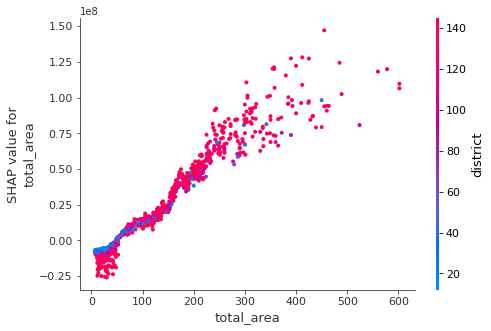

In [12]:
shap.initjs()
shap.dependence_plot("total_area", shap_values[X_t.index], X_t)

Как мы можем видеть, при увеличении total_area присутсвие этого признака в среднем повышает значение предсказания. Также мы можем видеть, что низкое значение общей площади соответсвует в среднем низкому значению district. 

Посмотрим на следующий график, который показывает распределение shap значений для каждого признака, обозначая величину признака цветом. Признаки отсортированы по сумме величин значений shap. Здесь мы можем видеть какие признаки более важны для модели, а какие меньше. Вверху находятся более важные признаки, внизу менее.

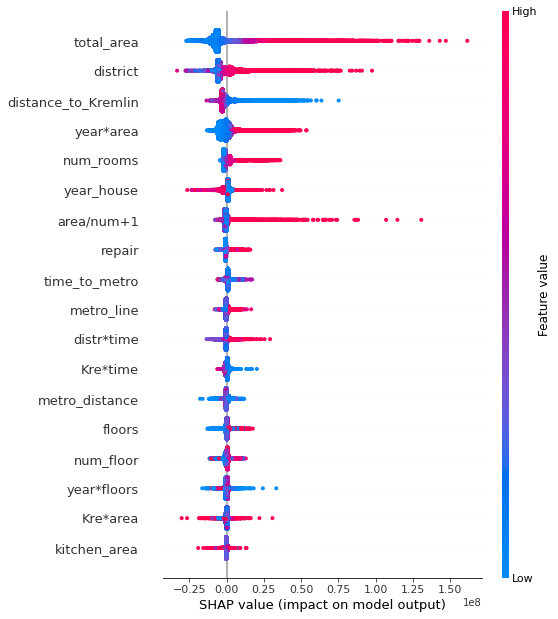

In [13]:
shap.summary_plot(shap_values, X)

Также мы можем делать выводы для конкретных признаков. Например, возьмем признак distance_to_Kremlin. Как мы можем видеть, при маленьких значениях присутствие этого признака в среднем увеличивает цену на квартиру, причем сильно увеличивает, а при больших значениях несильно уменьшает.
Что довольно логично, ведь чем ближе квартира к Кремлю, тем квартира стоит дороже.